In [30]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import requests
from IPython.display import Image, display
from io import BytesIO
from PIL import Image

In [46]:
data_path = r"DATA_PHOTOS_IAA_NUMBERS\\"
image_list = []
file_names = []

# Iterate over each file in the specified directory
for filename in os.listdir(data_path):
    if filename.endswith(('.jpg', '.png', '.tif')):
        file_path = os.path.join(data_path, filename)
        img = cv2.imread(file_path)
        # Append the image and its filename to the lists
        image_list.append(img)
        file_names.append(filename)

184

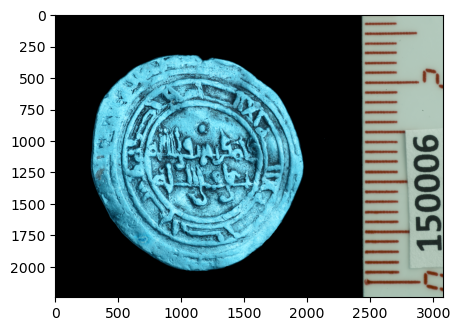

In [19]:
fig = plt.figure(figsize=(5, 6))
fig.add_subplot(1, 1, 1)
plt.imshow(image_list[0])

## First task

Isolate the coin from the image (remove the ruler and the note).

In [37]:
def crop_coin_simple(img, output_path):

    # Convert the image to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Define the lower and upper bounds of the color range for the coin
    lower_bound = np.array([20, 50, 50])  # Adjust these values based on the coin's color
    upper_bound = np.array([30, 255, 255])

    # Create a mask using the color range
    mask = cv2.inRange(hsv, lower_bound, upper_bound)

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Choose the largest contour (assumed to be the coin)
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Find extreme points (leftmost, rightmost, topmost, bottommost) of the contour
    leftmost = tuple(largest_contour[largest_contour[:,:,0].argmin()][0])
    rightmost = tuple(largest_contour[largest_contour[:,:,0].argmax()][0])
    topmost = tuple(largest_contour[largest_contour[:,:,1].argmin()][0])
    bottommost = tuple(largest_contour[largest_contour[:,:,1].argmax()][0])

    # Define the region of interest (ROI) using the coordinates of the bounding box
    roi = img[topmost[1]:bottommost[1], leftmost[0]:rightmost[0]]

    # Save the cropped region
    cv2.imwrite(output_path, roi)

In [38]:
def crop_images(output_dir , image_list, file_names):
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Process each image in image_list
    for idx, img in enumerate(image_list): 
        output_path = os.path.join(output_dir, file_names[idx])
        crop_coin_simple(img, output_path)
        #print(f"Image {idx} cropped and saved to {output_path}")

In [48]:
crop_images("REAL_DATA_CROPPED",image_list, file_names)

#### To use our images in a neural network, we need all the images to be the same size. We will add the right padding to ensure they are all uniform.

In [40]:
def add_padding(image, target_size):
    # Calculate padding dimensions
    h, w = image.shape[:2]
    target_h, target_w = target_size
    pad_h = max(0, target_h - h)
    pad_w = max(0, target_w - w)
    
    # Add padding to the image
    return cv2.copyMakeBorder(image, 0, pad_h, 0, pad_w, cv2.BORDER_CONSTANT, value=(0, 0, 0))

In [41]:
def find_max_dimensions(path):
    max_height, max_width = 0, 0
    image_files = [file for file in os.listdir(path) if file.endswith(('.jpg', '.png', '.tif'))]
    for file in image_files:
        img = cv2.imread(os.path.join(path, file))
        h, w = img.shape[:2]
        max_height = max(max_height, h)
        max_width = max(max_width, w)
    return max_height, max_width, image_files

In [42]:
def pad_images_and_save(input_path, output_path, max_dims):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    for file in os.listdir(input_path):
        if file.endswith(('.jpg', '.png', '.tif')):
            img = cv2.imread(os.path.join(input_path, file))
            padded_img = add_padding(img, max_dims)
            cv2.imwrite(os.path.join(output_path, file), padded_img)

In [49]:
# Paths
data_path = r"REAL_DATA_CROPPED"
output_dir = r"REAL_DATA_Padded"

# Process images
max_height, max_width, files = find_max_dimensions(data_path)
pad_images_and_save(data_path, output_dir, (max_height, max_width))

## combining two sides of each coin

In [44]:
# Function to combine two images
def combine_images(image1_path, image2_path, output_folder):
    # Load images
    image1 = cv2.imread(image1_path)
    image2 = cv2.imread(image2_path)

    # Resize images to have the same dimensions (optional, depends on your use case)
    image1 = cv2.resize(image1, (image2.shape[1], image2.shape[0]))

    # Combine images horizontally
    combined_image = cv2.hconcat([image1, image2])

    # Extract file names
    image1_name = os.path.basename(image1_path)
    image2_name = os.path.basename(image2_path)

    # Generate output file name
    output_filename = f"combined_{image1_name}_{image2_name}"
    
    # Save the combined image
    output_path = os.path.join(output_folder, output_filename)
    cv2.imwrite(output_path, combined_image)

In [45]:
# Path to your folder containing images
input_folder_path = r"REAL_DATA_Padded"
if not os.path.exists(input_folder_path):
    os.makedirs(input_folder_path)

# Path to the folder where combined images will be saved
output_folder_path = r"Combined_images"
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)

# Get a list of image files in the input folder
image_files = os.listdir(input_folder_path)

# Iterate through the image files to find pairs with names like "some.1" and "some.2"
for image_file in image_files:
    if image_file.endswith('.1.jpg') or image_file.endswith('.1.png') or image_file.endswith('.1.tif') :
        image1_path = os.path.join(input_folder_path, image_file)
        image2_name = image_file.replace(".1", ".2")
        image2_path = os.path.join(input_folder_path, image2_name)
        if os.path.exists(image2_path):
            combine_images(image1_path, image2_path, output_folder_path)